In [1]:
import os

os.makedirs('../out/', exist_ok=True)

STATS_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Stats.parquet',
    'HSC_Lecco_2024': '../data/HSC_Lecco_2024-Players_Daily_Mobility_Stats.parquet',
    'HSC_Ferrara_2023': '../data/HSC_Ferrara_2023-Players_Daily_Mobility_Stats.parquet',
}

SCORES_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Scores.parquet',
    'HSC_Lecco_2024': '../data/HSC_Lecco_2024-Players_Daily_Mobility_Scores.parquet',
    'HSC_Ferrara_2023': '../data/HSC_Ferrara_2023-Players_Daily_Mobility_Scores.parquet',
}

In [2]:
import pandas as pd
import numpy as np

def load_stats(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df['distance'] = df['distance'] / 1000 # convert to km
    df['campaign'] = c
    df.rename(columns={'modeType': 'counter', 'distance': 'score', 'stat_date': 'ts'}, inplace=True)
    return df[['playerId', 'campaign', 'ts', 'counter', 'score']]

def load_scores(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df.rename(columns={'player_id': 'playerId', 'mobilityScore': 'score', 'day': 'ts'}, inplace=True)
    df['counter'] = 'score'
    df['campaign'] = c
    return df[['playerId', 'campaign', 'ts', 'counter', 'score']]

df_stats = pd.concat([load_stats(f, k) for k, f in STATS_FILES.items()])
df_scores = pd.concat([load_scores(f, k) for k, f in SCORES_FILES.items()])

df = pd.concat([df_stats, df_scores])
df['ts'] = pd.to_datetime(df['ts'])

df = df.groupby(['playerId', 'campaign', 'counter']).resample('W', on='ts').sum(numeric_only=True).reset_index()
df['score'] = df['score'].round(2)
df

,playerId,campaign,counter,ts,score
0,u_00144002f1614ee9a45f7822760e3746,HSC_Lecco_2023,score,2023-03-05,15.00
1,u_00144002f1614ee9a45f7822760e3746,HSC_Lecco_2023,walk,2023-03-05,1.21
2,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,bus,2023-03-05,6.48
3,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,bus,2023-03-12,0.00
4,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,bus,2023-03-19,0.00
...,...,...,...,...,...
20654,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,bus,2024-03-24,32.91
20655,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,score,2024-03-03,100.00
20656,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,score,2024-03-10,108.00
20657,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,score,2024-03-17,182.00


In [3]:
def flatten(df: pd.DataFrame):
    return pd.Series({
        'start': df['ts'].min(),
        'scores': df[['walk', 'bike', 'train', 'bus', 'car', 'score']].values
    })

flattened_df = df.pivot(index=['playerId', 'campaign', 'ts'], columns='counter', values='score').fillna(0).reset_index()
flattened_df = flattened_df.groupby(['playerId', 'campaign']).apply(flatten, include_groups=False).reset_index()
flattened_df = flattened_df[flattened_df['scores'].apply(lambda x: np.sum(x) > 0 and len(x) > 2)]
flattened_df.sort_values('start', inplace=True)
flattened_df

,playerId,campaign,start,scores
456,u_68a8eb940a5b4a98b7421090a8d77c42,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.17, 5.01, ..."
668,u_9aa7ad833f8449849ee9ec3e62924591,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [11.34, 0.0, ..."
245,u_3a209c2a3fff4c5f8a5553fd212760e7,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [14.59, 0.0, ..."
117,u_1a125c7cf4cb4abdaa9d5b8f1d866fdf,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [4.89, 0.27, ..."
344,u_4e195140e9e443fa8e52d36d6e226c25,HSC_Lecco_2023,2023-02-26,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...."
...,...,...,...,...
758,u_b0a9dd7b9ca14c3c91d83bc4edab443d,HSC_Lecco_2024,2024-03-24,"[[28.81, 0.0, 0.0, 0.0, 0.0, 474.0], [16.14, 0..."
828,u_c05bd6bb4a73422b81fd92debd1a5e30,HSC_Lecco_2024,2024-03-24,"[[5.42, 0.0, 0.0, 64.0, 0.0, 325.0], [1.44, 0...."
480,u_6dd341e8728145b0a4dbe5ba16c4819b,HSC_Lecco_2024,2024-03-24,"[[4.39, 0.0, 0.0, 307.96, 0.0, 491.0], [4.59, ..."
883,u_cbd5018a25e94695a23f862b8b539e9f,HSC_Lecco_2024,2024-03-31,"[[0.0, 0.0, 0.0, 5.16, 0.0, 16.0], [0.0, 0.0, ..."


,playerId,campaign,start,scores,n
883,u_cbd5018a25e94695a23f862b8b539e9f,HSC_Lecco_2024,2024-03-31,"[[0.0, 0.0, 0.0, 5.16, 0.0, 16.0], [0.0, 0.0, ...",7
682,u_9e6a9554ecdb4d55a6e429e1865cec8f,HSC_Lecco_2023,2023-03-05,"[[13.88, 0.0, 0.0, 0.0, 0.0, 130.0], [18.1, 0....",7
663,u_991ef08fdf134b2b8c25df5ddbcda4a8,HSC_Lecco_2024,2024-03-03,"[[0.0, 0.0, 0.0, 126.56, 0.0, 204.0], [0.49, 0...",7
208,u_330803ed1ab84d149c6799a73e409b4c,HSC_Lecco_2024,2024-03-03,"[[0.0, 0.0, 0.0, 7.04, 0.0, 18.0], [2.49, 0.0,...",7
781,u_b625dff37e404f689daf353f7540e0d1,HSC_Lecco_2024,2024-03-03,"[[0.0, 0.0, 31.57, 22.0, 0.0, 77.0], [4.49, 0....",7
772,u_b438886d7ad44c979f90692c652aa7b5,HSC_Lecco_2024,2024-03-03,"[[5.59, 0.0, 222.25, 0.0, 0.0, 198.0], [0.0, 0...",7
686,u_a0467d30e0394f5a93f500129d219c7a,HSC_Lecco_2024,2024-03-03,"[[0.0, 0.0, 8.61, 0.0, 0.0, 13.0], [1.53, 0.0,...",7
230,u_371bc5b5c5c7447786ecd53316ab9fca,HSC_Lecco_2024,2024-03-03,"[[0.0, 0.0, 0.0, 6.21, 0.0, 19.0], [0.0, 0.0, ...",7
181,u_2d62038170d04a3a930018428465beef,HSC_Lecco_2024,2024-03-03,"[[1.34, 0.0, 0.0, 14.94, 7.1, 78.0], [1.05, 0....",7
383,u_563c56eeedf8424488aa3f5ff45aad8c,HSC_Lecco_2024,2024-03-03,"[[3.05, 0.0, 0.0, 10.68, 0.0, 78.0], [4.65, 0....",7


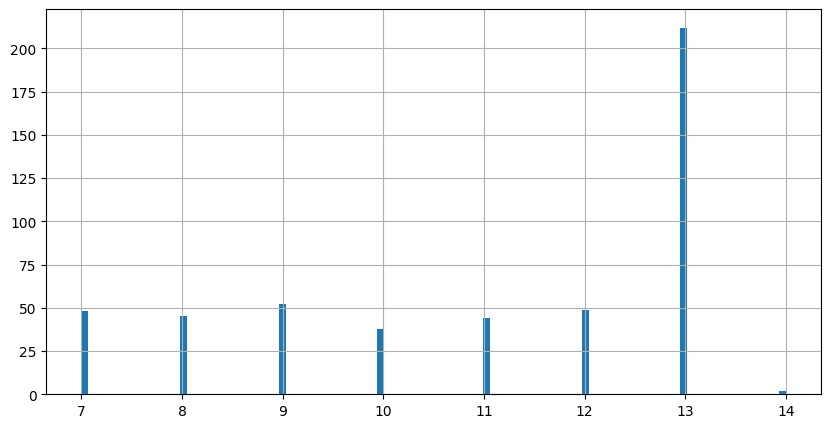

In [4]:
flattened_df['n'] = flattened_df['scores'].apply(lambda x: x.shape[0])
flattened_df = flattened_df[flattened_df['n'] > 6]

flattened_df['n'].hist(bins=100, figsize=(10, 5))

flattened_df.sort_values('n', ascending=True).head(10)

## Time-series analysis

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

class PerformancePredictor(nn.Module):
    def fit(self, X, y, epochs=100, lr=0.01):
        self.to(DEVICE)
        self.train()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for _ in range(epochs):
            optimizer.zero_grad()
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            output = self(X)
            loss: torch.Tensor = criterion(output, y)
            loss.backward()
            optimizer.step()
        self.eval()
        return self
    
    def predict(self, X):
        self.to(DEVICE)
        self.eval()
        X = X.to(DEVICE)
        return self(X).cpu().detach().numpy()

class PerformancePredictorRNN(PerformancePredictor):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, layers: int = 1, dropout: float = 0.0):
        super(PerformancePredictorRNN, self).__init__()
        self.hidden_size = hidden_size
        dropout = 0.0 if layers == 1 else dropout

        assert layers >= 1
        self.rnn = nn.RNN(input_size, hidden_size, layers, bidirectional=False, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[-1, :]
        out = self.fc(out)
        return out

cuda


In [8]:
from sklearn.preprocessing import StandardScaler as scaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm
tqdm.pandas()

def cross_validate(x: pd.Series):
    dataframe = x['scores']
    tscv = TimeSeriesSplit(n_splits=5, test_size=1)
    folds = {
        'playerId': x['playerId'],
        'campaign': x['campaign'],
    }
    i=0
    for train_index, test_index in tscv.split(dataframe):
        assert len(test_index) == 1
        split = dataframe[np.concatenate([train_index, test_index])]
        sc = scaler()
        sc = sc.fit(split[train_index])
        split = sc.transform(split)

        model = PerformancePredictorRNN(
            input_size=6,
            hidden_size=64, 
            output_size=6,
            layers=2,
            dropout=0.5
        )
        X_train = torch.tensor(split[train_index[:-1]], dtype=torch.float32)
        y_train = torch.tensor(split[train_index[-1]], dtype=torch.float32)
        model = model.fit(X_train, y_train, epochs=200, lr=1e-4)

        X = torch.tensor(split[train_index], dtype=torch.float32)
        y = torch.tensor(split[test_index], dtype=torch.float32)
        y_pred = model.predict(X)

        y_pred = sc.inverse_transform(y_pred.reshape(1, -1)).flatten()
        y_pred = np.maximum(0, y_pred) # avoid negative values
        y = sc.inverse_transform(y.numpy().reshape(1, -1)).flatten()

        folds[f"fold_{i}"] = np.array([y, y_pred])
        i += 1

    return pd.Series(folds)

Y_hat: pd.DataFrame = flattened_df.progress_apply(cross_validate, axis=1)

rmse = []
for i in Y_hat.columns[-5:]:
    values = np.array(Y_hat[i].values.tolist())
    rmse.append(root_mean_squared_error(values[:, 0, :], values[:, 1, :], multioutput='raw_values'))

pd.DataFrame({
    'rmse': np.array(rmse).mean(axis=0),
    'std': np.array(rmse).std(axis=0),
}, index=['walk', 'bike', 'train', 'bus', 'car', 'score']).map('{:.2f}'.format)

100%|██████████| 490/490 [07:06<00:00,  1.15it/s]


,rmse,std
walk,5.83,0.66
bike,7.24,0.79
train,38.80,3.70
bus,19.54,2.30
car,19.02,9.24
score,108.58,7.02


In [7]:
# Current predictor: moving average of the last 4 weeks

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm
tqdm.pandas()

def cross_validate(x: pd.Series):
    dataframe = x['scores']
    tscv = TimeSeriesSplit(n_splits=5, test_size=1)
    folds = {
        'playerId': x['playerId'],
        'campaign': x['campaign'],
    }
    i = 0
    for train_index, test_index in tscv.split(dataframe):
        assert len(test_index) == 1
        split = dataframe[np.concatenate([train_index, test_index])]
        X = split[train_index[-4:]]
        y = split[test_index].flatten()
        y_pred = X.mean(axis=0)
        
        folds[f"fold_{i}"] = np.array([y, y_pred])
        i += 1

    return pd.Series(folds)

Y_hat: pd.DataFrame = flattened_df.progress_apply(cross_validate, axis=1)

rmse = []
for i in Y_hat.columns[-5:]:
    values = np.array(Y_hat[i].values.tolist())
    rmse.append(root_mean_squared_error(values[:, 0, :], values[:, 1, :], multioutput='raw_values'))

pd.DataFrame({
    'rmse': np.array(rmse).mean(axis=0),
    'std': np.array(rmse).std(axis=0),
}, index=['walk', 'bike', 'train', 'bus', 'car', 'score']).map('{:.2f}'.format)

100%|██████████| 490/490 [00:00<00:00, 4689.07it/s]


,rmse,std
walk,5.77,0.80
bike,6.84,0.85
train,37.36,2.40
bus,20.65,1.62
car,18.61,3.21
score,107.04,7.84
